In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Feb 20 09:24:06 2025
@author: María
"""

import pandas as pd
import numpy as np
np.NaN = np.nan  # Fix incorrect import in pandas_ta

import os
import warnings
# Silencia logs de TensorFlow (0 = todos, 1 = errores, 2 = errores + warnings, 3 = solo errores críticos)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# Silencia FutureWarnings de pandas / numpy / pandas_ta
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas_ta as ta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.utils import to_categorical

# Lista de ETFs
ETFS = ['XLF', 'XLU', 'XLI', 'SPY', 'XLP', 'EWG', 'XLB', 'XLK', 'XLV', 'EWH', 'EWC', 'XLY', 'EWW', 'DIA', 'XLE', 'EWA', 'EWJ']

def add_indicators(dataf):
    """Calculate 28 technical indicators efficiently without fragmentation"""
    # Create a list to store all new indicator DataFrames
    indicator_dfs = []
    
    for etf in ETFS:
        # Create a temporary DataFrame for this ETF's indicators
        etf_indicators = pd.DataFrame(index=dataf.index)
        
        # Extract base columns once
        close = dataf[('Close', etf)]
        high = dataf[('High', etf)]
        low = dataf[('Low', etf)]
        volume = dataf[('Volume', etf)]
        
        # RSI indicators
        etf_indicators[('RSI_15', etf)] = ta.rsi(close, length=15)
        etf_indicators[('RSI_20', etf)] = ta.rsi(close, length=20)
        etf_indicators[('RSI_25', etf)] = ta.rsi(close, length=25)
        etf_indicators[('RSI_30', etf)] = ta.rsi(close, length=30)
        
        # SMA indicators
        etf_indicators[('SMA_15', etf)] = ta.sma(close, length=15)
        etf_indicators[('SMA_20', etf)] = ta.sma(close, length=20)
        etf_indicators[('SMA_25', etf)] = ta.sma(close, length=25)
        etf_indicators[('SMA_30', etf)] = ta.sma(close, length=30)
        
        # MACD indicators
        macd12 = ta.macd(close, fast=26, slow=12)
        etf_indicators[('MACD_12', etf)] = macd12['MACD_12_26_9']
        etf_indicators[('MACDh_12', etf)] = macd12['MACDh_12_26_9']
        
        macd14 = ta.macd(close, fast=28, slow=14)
        etf_indicators[('MACD_14', etf)] = macd14['MACD_14_28_9']
        etf_indicators[('MACDh_14', etf)] = macd14['MACDh_14_28_9']
        
        macd16 = ta.macd(close, fast=30, slow=16)
        etf_indicators[('MACD_16', etf)] = macd16['MACD_16_30_9']
        etf_indicators[('MACDh_16', etf)] = macd16['MACDh_16_30_9']
        
        # WILLR indicators
        etf_indicators[('WILLR_14', etf)] = ta.willr(high, low, close, length=14)
        etf_indicators[('WILLR_18', etf)] = ta.willr(high, low, close, length=18)
        etf_indicators[('WILLR_22', etf)] = ta.willr(high, low, close, length=22)
        
        # STOCH indicators
        stoch14 = ta.stoch(high, low, close, k=14)
        etf_indicators[('STOCH_14', etf)] = stoch14['STOCHk_14_3_3'] - stoch14['STOCHd_14_3_3']
        
        stoch18 = ta.stoch(high, low, close, k=18)
        etf_indicators[('STOCH_18', etf)] = stoch18['STOCHk_18_3_3'] - stoch18['STOCHd_18_3_3']
        
        stoch22 = ta.stoch(high, low, close, k=22)
        etf_indicators[('STOCH_22', etf)] = stoch22['STOCHk_22_3_3'] - stoch22['STOCHd_22_3_3']

        # UO indicators
        etf_indicators[('UO_7', etf)] = ta.uo(high, low, close, fast=7, medium=14, slow=28)
        etf_indicators[('UO_8', etf)] = ta.uo(high, low, close, fast=8, medium=16, slow=32)
        etf_indicators[('UO_9', etf)] = ta.uo(high, low, close, fast=9, medium=18, slow=36)

        # MFI indicators
        etf_indicators[('MFI_14', etf)] = ta.mfi(high, low, close, volume, length=14)
        etf_indicators[('MFI_18', etf)] = ta.mfi(high, low, close, volume, length=18)
        etf_indicators[('MFI_22', etf)] = ta.mfi(high, low, close, volume, length=22)

        # Close transformation
        close_diff = close.diff()
        etf_indicators[('Close_Tanh', etf)] = np.tanh(close_diff)
        
        # Add this ETF's indicators to the list
        indicator_dfs.append(etf_indicators)
    
    # Concatenate all indicators at once
    all_indicators = pd.concat(indicator_dfs, axis=1)
    
    # Combine with original data
    result_df = pd.concat([dataf, all_indicators], axis=1)
    
    # Drop intermediate columns
    cols_to_drop = []
    for etf in ETFS:
        cols_to_drop.extend([
            ('Close_Diff', etf),
            ('High', etf),
            ('Low', etf),
            ('Open', etf)
        ])
    
    result_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
    
    return result_df.dropna()



def cluster_features(dataf):
    """Cluster features using hierarchical clustering"""
    # Prepare data for clustering
    feature_columns = []
    for col in dataf.columns.get_level_values(0).unique():
        if col not in ['Open', 'High', 'Low', 'Close']:
            for etf in ETFS:
                if (col, etf) in dataf.columns:
                    feature_columns.append((col, etf))
    
    # Extract feature data
    feature_data = dataf[feature_columns].copy()
    
    # Transpose to get features as rows (features x time)
    feature_data = feature_data.T
    
    # Calculate correlation matrix
    corr_matrix = feature_data.T.corr().abs()
    
    # Convert correlation to distance matrix
    distance_matrix = 1 - corr_matrix
    np.fill_diagonal(distance_matrix.values, 0)
    
    # Perform hierarchical clustering
    condensed_dist = squareform(distance_matrix)
    Z = linkage(condensed_dist, method='ward')
    order = leaves_list(Z)
    
    # Get clustered feature order
    clustered_features = feature_data.index[order].tolist()
    
    # Add Volume and Close_Tanh to the clustered features
    final_feature_order = []
    for etf in ETFS:
        # Add Close_Tanh and Volume first as per paper
        final_feature_order.append(('Close_Tanh', etf))
        final_feature_order.append(('Volume', etf))
        # Add other clustered features
        for feature in clustered_features:
            if feature[1] == etf:
                final_feature_order.append(feature)
    
    return final_feature_order

def create_images(dataf, feature_order, window_size=28):
    """Create 28x28 images using clustered feature order"""
    images = []
    targets = []
    dates = []
    prices = []  # Store actual prices
    
    for etf in ETFS:
        # Get ETF-specific features
        etf_features = [col for col in feature_order if col[1] == etf]
        
        # Skip if no features found for this ETF
        if not etf_features:
            continue
            
        etf_df = dataf[etf_features].copy()
        
        # Standardize features
        scaler = StandardScaler()
        scaled_values = scaler.fit_transform(etf_df)
        etf_df.loc[:, :] = scaled_values
        
        # Create sliding windows
        for i in range(len(etf_df) - window_size):
            window = etf_df.iloc[i:i+window_size].values
            
            # Create 28x28 image
            n_features = window.shape[1]
            if n_features < window_size:
                # Pad with zeros if fewer features
                padded_window = np.zeros((window_size, window_size))
                padded_window[:, :n_features] = window
                image = padded_window
            else:
                # Use the first window_size features
                image = window[:, :window_size]
            
            # Reshape for CNN (28, 28, 1)
            image = image.reshape(window_size, window_size, 1)
            
            # Target is next day's transformed close
            target = dataf[('Close_Tanh', etf)].iloc[i+window_size]
            date = dataf.index[i+window_size]
            price = dataf[('Close', etf)].iloc[i+window_size]  # Actual close price
            
            images.append(image)
            targets.append(target)
            dates.append(date)
            prices.append(price)
    
    return np.array(images), np.array(targets), np.array(dates), np.array(prices)

def build_cnn_model(input_shape, model_type='regr'):
    """Build CNN model based on paper's architecture"""
    model = Sequential([
        Input(shape=input_shape),
        # First Convolutional Layer
        Conv2D(32, (3, 3), activation='relu'),
        # Second Convolutional Layer
        Conv2D(64, (3, 3), activation='relu'),
        # Max Pooling Layer
        MaxPooling2D((4, 4)),
        # Dropout Layer
        Dropout(0.25),
        # Flatten the feature maps
        Flatten(),
        # Fully Connected Layer
        Dense(128, activation='relu'),
        Dropout(0.5)
    ])
    
    # Output Layer
    if model_type == 'regr':
        model.add(Dense(1, activation='linear'))
        model.compile(optimizer=Adadelta(learning_rate=0.1), 
                     loss='mse', 
                     metrics=['mae'])
    elif model_type == 'class2':
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=Adadelta(learning_rate=0.1), 
                     loss='binary_crossentropy', 
                     metrics=['accuracy', Precision(), Recall(), AUC()])
    elif model_type == 'class3':
        model.add(Dense(3, activation='softmax'))
        model.compile(optimizer=Adadelta(learning_rate=0.1), 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy', Precision(), Recall(), AUC()])
    
    return model

def train_models(X_train, y_train_regr, X_test, y_test_regr):
    """Train regression and classification models"""
    # Get input shape from data
    input_shape = X_train.shape[1:]
    
    # Convert targets for classification
    y_train_class2 = (y_train_regr > 0).astype(int)
    y_test_class2 = (y_test_regr > 0).astype(int)
    
    y_train_class3 = np.zeros_like(y_train_regr, dtype=int)
    y_train_class3[y_train_regr <= -0.38] = 0
    y_train_class3[(y_train_regr > -0.38) & (y_train_regr <= 0.38)] = 1
    y_train_class3[y_train_regr > 0.38] = 2
    y_train_class3 = to_categorical(y_train_class3, num_classes=3)
    
    y_test_class3 = np.zeros_like(y_test_regr, dtype=int)
    y_test_class3[y_test_regr <= -0.38] = 0
    y_test_class3[(y_test_regr > -0.38) & (y_test_regr <= 0.38)] = 1
    y_test_class3[y_test_regr > 0.38] = 2
    y_test_class3 = to_categorical(y_test_class3, num_classes=3)
    
    # Regression model
    model_regr = build_cnn_model(input_shape, 'regr')
    history_regr = model_regr.fit(X_train, y_train_regr, 
                                 epochs=50, 
                                 batch_size=32,
                                 validation_data=(X_test, y_test_regr),
                                 verbose = 0)
    plot_training_history(history_regr, 'regr')
    
    # Binary classification model
    model_class2 = build_cnn_model(input_shape, 'class2')
    history_class2 = model_class2.fit(X_train, y_train_class2, 
                                     epochs=50, 
                                     batch_size=32,
                                     validation_data=(X_test, y_test_class2), 
                                     verbose = 0)
    plot_training_history(history_class2, 'class2')
    
    # 3-class classification model
    model_class3 = build_cnn_model(input_shape, 'class3')
    history_class3 = model_class3.fit(X_train, y_train_class3, 
                                     epochs=50, 
                                     batch_size=32,
                                     validation_data=(X_test, y_test_class3),
                                     verbose = 0)
    plot_training_history(history_class3, 'class3')
    
    return model_regr, model_class2, model_class3, history_regr, history_class2, history_class3




def plot_training_history(history, model_type):
    """
    Plot training and validation metrics for a given history object
    
    Args:
        history: Keras History object returned from model.fit()
        model_type: Type of model ('regr', 'class2', or 'class3')
    """
    # Create main figure
    main_fig = plt.figure(figsize=(15, 10))
    
    # Define metric suffixes based on model type
    suffix = "_1" if model_type == "class3" else ""
    
    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Evolution')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    
    # Plot appropriate metrics based on model type
    if model_type == 'regr':
        # Regression metrics
        plt.subplot(2, 2, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('Mean Absolute Error')
        plt.ylabel('MAE')
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(2, 2, 3)
        plt.plot(history.history['loss'], history.history['mae'], 'o-')
        plt.title('Loss vs MAE')
        plt.xlabel('Loss')
        plt.ylabel('MAE')
        plt.grid(True)
        
        # Save and show main figure for regression
        plt.tight_layout()
        plt.savefig(f'training_history_{model_type}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    else:
        # Classification metrics
        plt.subplot(2, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True)
        
        # Check for precision with suffix
        precision_key = f'precision{suffix}'
        if precision_key in history.history:
            # Precision-Recall AUC with suffix handling
            recall_key = f'recall{suffix}'
            auc_key = f'auc{suffix}'
            
            plt.subplot(2, 2, 3)
            plt.plot(history.history[precision_key], label='Training Precision')
            plt.plot(history.history[f'val_{precision_key}'], label='Validation Precision')
            plt.title('Precision')
            plt.ylabel('Precision')
            plt.xlabel('Epoch')
            plt.legend()
            plt.grid(True)
            
            plt.subplot(2, 2, 4)
            plt.plot(history.history[recall_key], label='Training Recall')
            plt.plot(history.history[f'val_{recall_key}'], label='Validation Recall')
            plt.title('Recall')
            plt.ylabel('Recall')
            plt.xlabel('Epoch')
            plt.legend()
            plt.grid(True)
            
            # Save and show main figure FIRST
            plt.tight_layout()
            plt.savefig(f'training_history_{model_type}.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Create ADDITIONAL figure for AUC
            if auc_key in history.history:
                auc_fig = plt.figure(figsize=(15, 5))
                plt.subplot(1, 2, 1)
                plt.plot(history.history[auc_key], label='Training AUC')
                plt.plot(history.history[f'val_{auc_key}'], label='Validation AUC')
                plt.title('AUC')
                plt.ylabel('AUC')
                plt.xlabel('Epoch')
                plt.legend()
                plt.grid(True)
                
                plt.subplot(1, 2, 2)
                plt.plot(history.history[precision_key], history.history[recall_key], 'o-')
                plt.title('Precision vs Recall')
                plt.xlabel('Precision')
                plt.ylabel('Recall')
                plt.grid(True)
                plt.tight_layout()
                plt.savefig(f'auc_pr_{model_type}.png', dpi=300, bbox_inches='tight')
                plt.show()
                
        else:
            # Fallback to AUC if precision not available
            auc_key = f'auc{suffix}'
            if auc_key in history.history:
                plt.subplot(2, 2, 3)
                plt.plot(history.history[auc_key], label='Training AUC')
                plt.plot(history.history[f'val_{auc_key}'], label='Validation AUC')
                plt.title('AUC')
                plt.ylabel('AUC')
                plt.xlabel('Epoch')
                plt.legend()
                plt.grid(True)
                
                plt.subplot(2, 2, 4)
                plt.plot(history.history['accuracy'], history.history['loss'], 'o-')
                plt.title('Accuracy vs Loss')
                plt.xlabel('Accuracy')
                plt.ylabel('Loss')
                plt.grid(True)
            
            # Save and show main figure for classification
            plt.tight_layout()
            plt.savefig(f'training_history_{model_type}.png', dpi=300, bbox_inches='tight')
            plt.show()
    



def print_metrics(model_type, y_true, y_pred, y_pred_proba=None):
    """Print evaluation metrics for the model"""
    print("\n" + "="*50)
    print(f"MODEL EVALUATION METRICS: {model_type.upper()} MODEL")
    print("="*50)
    
    if model_type == 'regr':
        # Regression metrics
        print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
        print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
        print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
        print(f"R²: {r2_score(y_true, y_pred):.4f}")
        
    else:
        # Classification metrics - handle zero division
        try:
            precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        except:
            precision = 0.0
            
        try:
            recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        except:
            recall = 0.0
            
        try:
            f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        except:
            f1 = 0.0
        
        print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        

    
    print("="*50 + "\n")
    
    
def backtest_strategy(signals, test_prices, initial_capital=10000, transaction_cost=5):
    """Backtest trading strategy with transaction costs"""
    capital = initial_capital
    position = 0  # Number of shares held
    in_position = False
    trade_count = 0
    
    # We'll assume we can only trade whole shares
    for i in range(len(signals)):
        current_price = test_prices[i]
        
        # Close position if signal changes and we're in a position
        if in_position and ((signals[i] == 0) or (i == len(signals)-1)):
            # Sell all shares
            capital += position * current_price
            capital -= transaction_cost
            position = 0
            in_position = False
            trade_count += 1
            
        # Open new long position
        if not in_position and signals[i] == 1:
            # Calculate how many shares we can buy
            shares = capital // current_price
            if shares > 0:
                position = shares
                capital -= position * current_price
                capital -= transaction_cost
                in_position = True
                trade_count += 1
                
        # Open new short position (if allowed)
        # if not in_position and signals[i] == -1:
        #   Implement short selling logic if needed
    
    # Close final position if still open
    if in_position:
        capital += position * current_price
        capital -= transaction_cost
        trade_count += 1
    
    return capital, trade_count



2025-06-19 09:15:41.486833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750317341.500876 2626314 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750317341.505443 2626314 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750317341.516257 2626314 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750317341.516284 2626314 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750317341.516285 2626314 computation_placer.cc:177] computation placer alr

In [2]:
DF = pd.read_csv("dfmultiple.csv", index_col=0, header=[0,1])
    
# Convert index to datetime
DF.index = pd.to_datetime(DF.index)



# Calculate indicators and transform close price
print("Adding technical indicators...")
df = add_indicators(DF)

Adding technical indicators...


In [3]:
# Cluster features
print("Clustering features...")
feature_order = cluster_features(df)

Clustering features...


In [4]:
# Create images
print("Creating images...")
X, y, dates, prices = create_images(df, feature_order)  # Added prices in return

# Convert dates array 
dates = pd.to_datetime(dates)

# Sort by date (important for time-series split)
sorted_indices = np.argsort(dates)
X = X[sorted_indices]
y = y[sorted_indices]
dates = dates[sorted_indices]
prices = prices[sorted_indices]

# Proportional split (90% train, 10% test) as in paper
split_idx = int(len(X) * 0.9)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
test_dates = dates[split_idx:]
test_prices = prices[split_idx:]

print(f"Training period: {dates[0].date()} to {dates[split_idx-1].date()}")
print(f"Testing period: {dates[split_idx].date()} to {dates[-1].date()}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Creating images...
Training period: 2020-04-06 to 2023-08-16
Testing period: 2023-08-16 to 2023-12-29
Training samples: 14397
Testing samples: 1600


Training models...


W0000 00:00:1750317346.741236 2626314 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


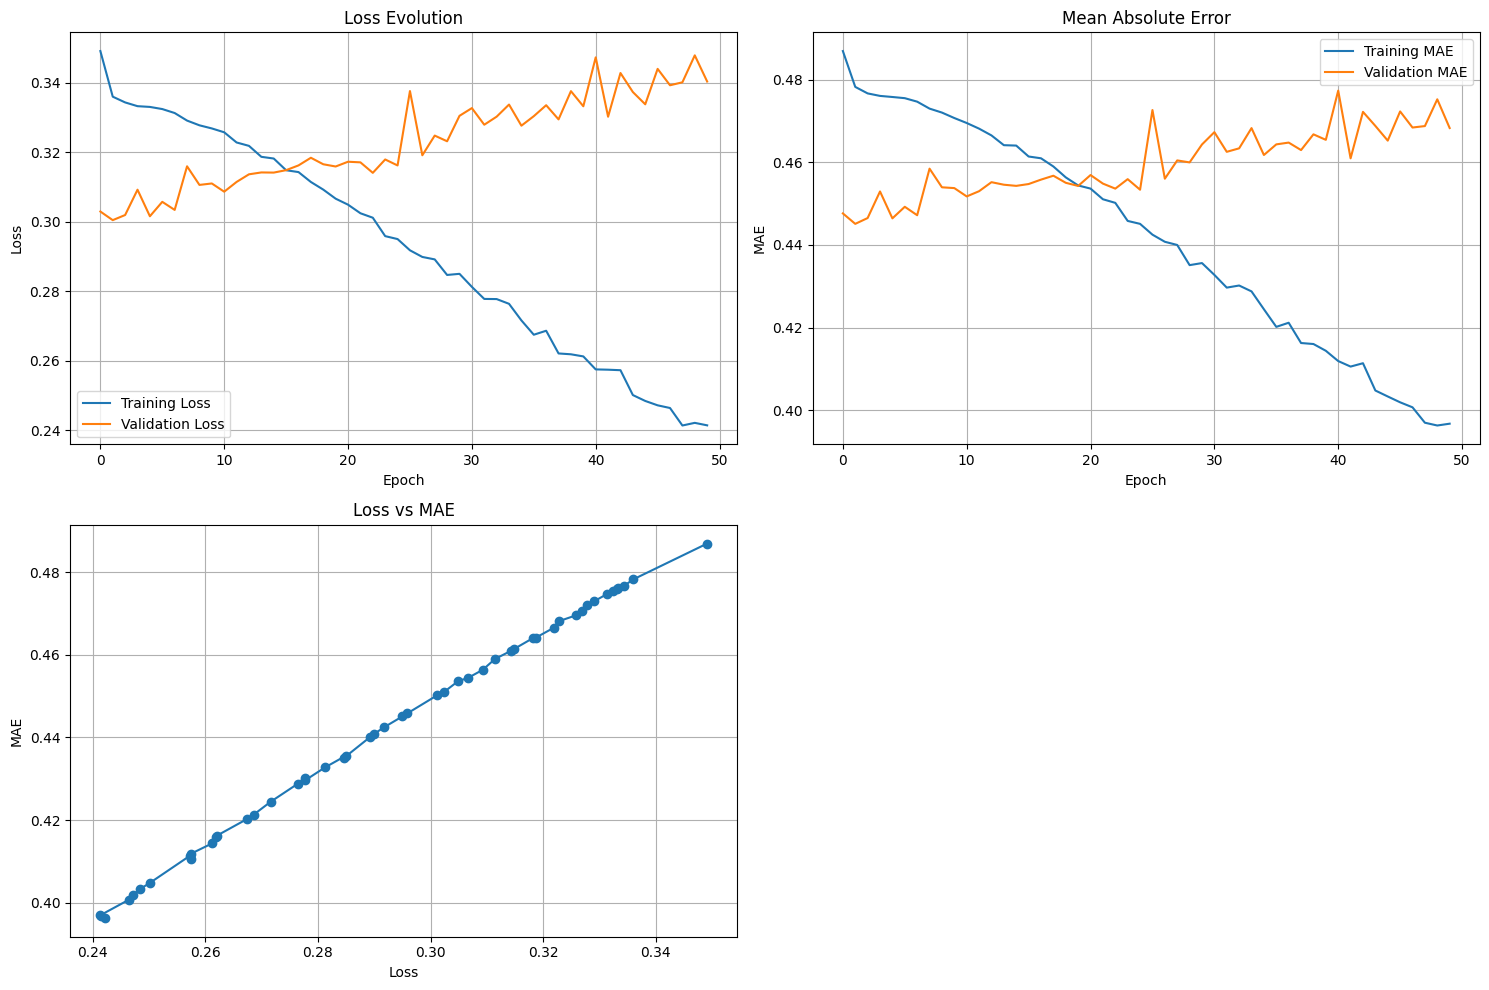

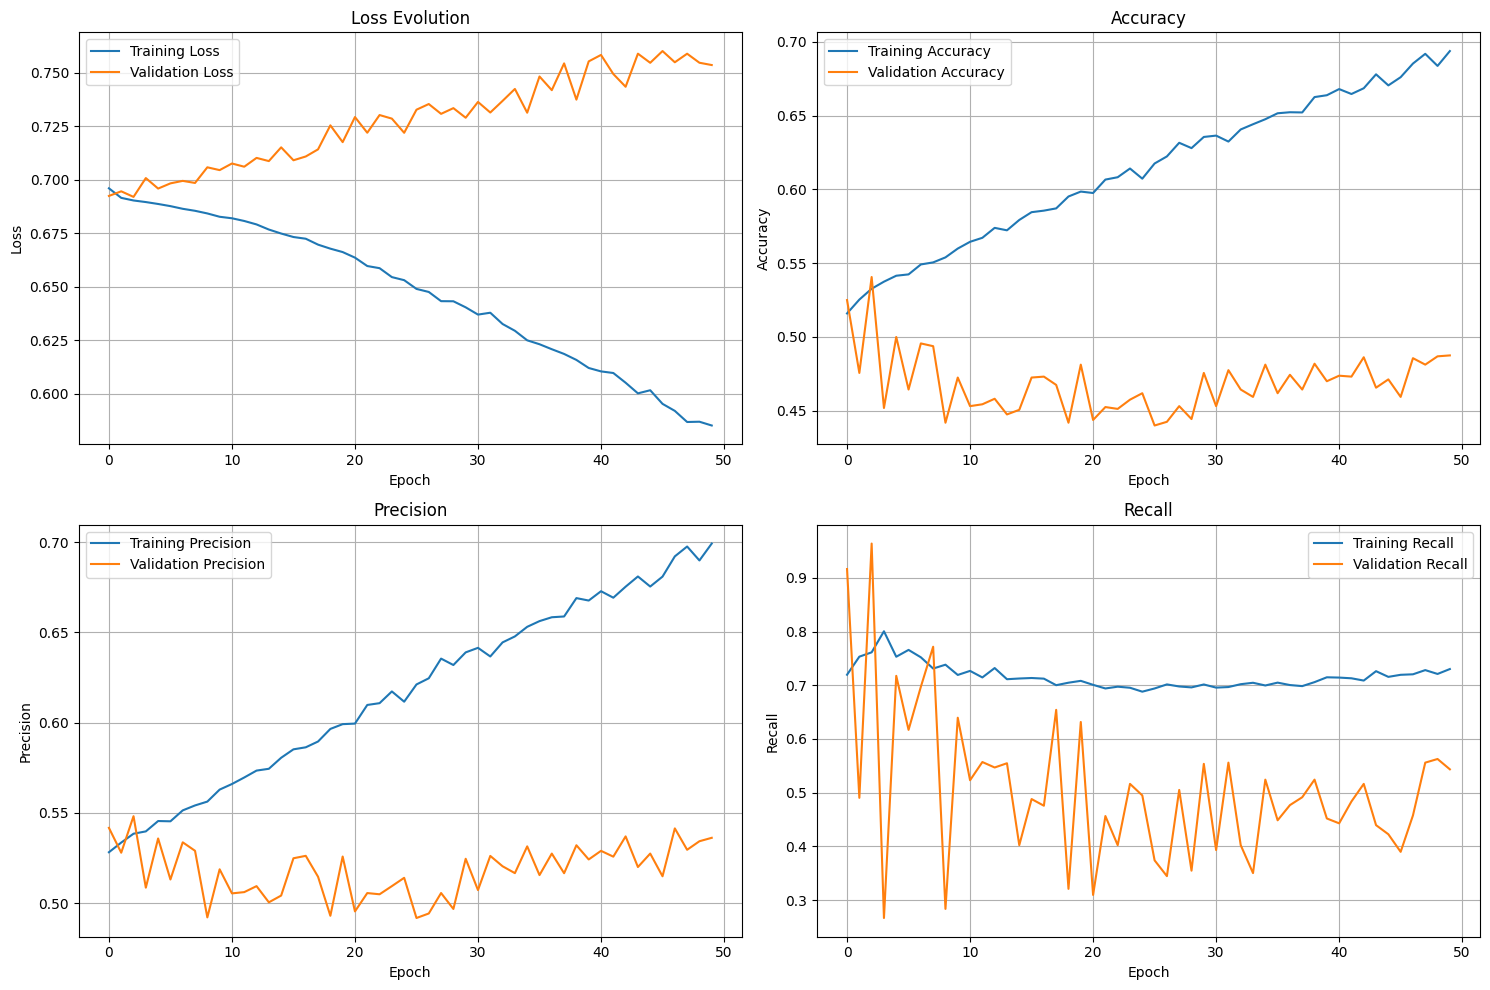

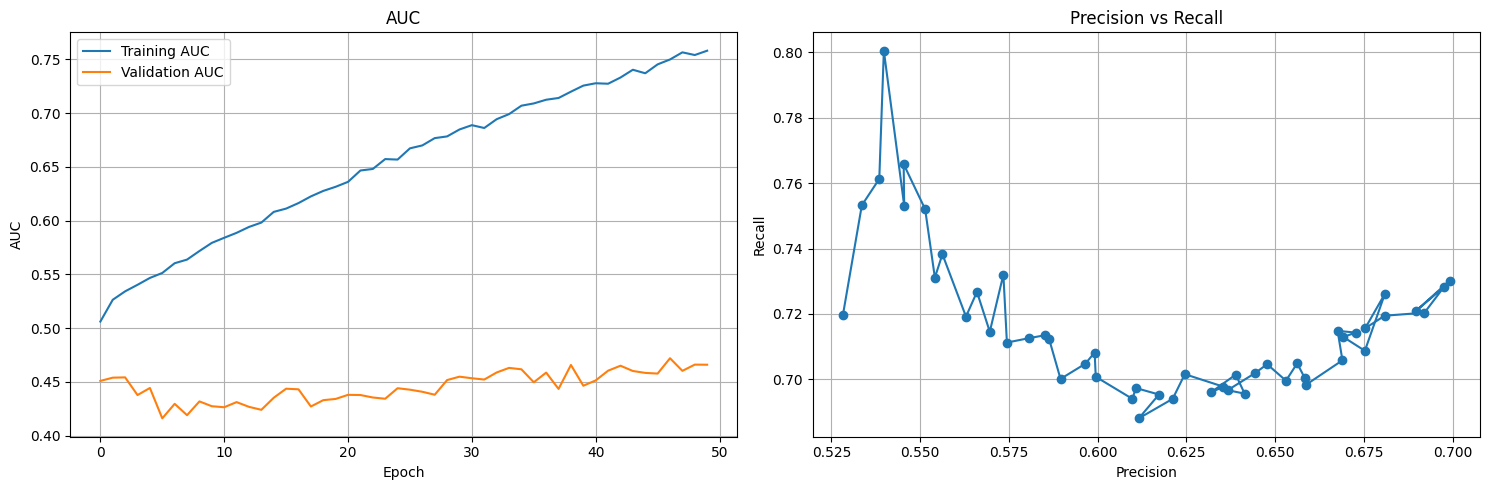

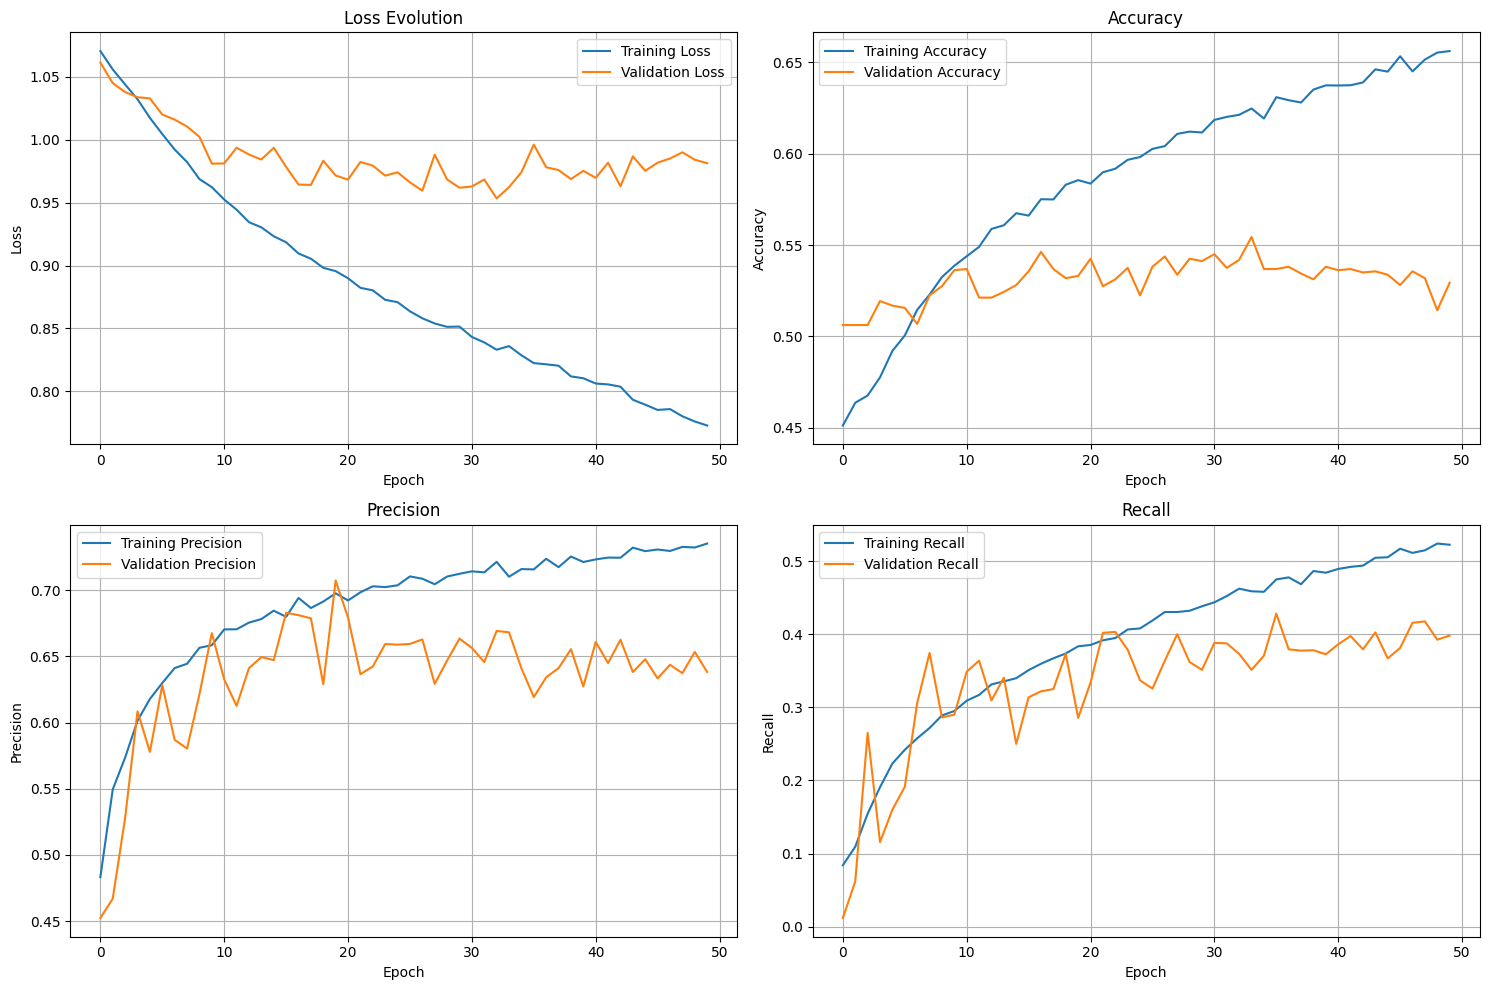

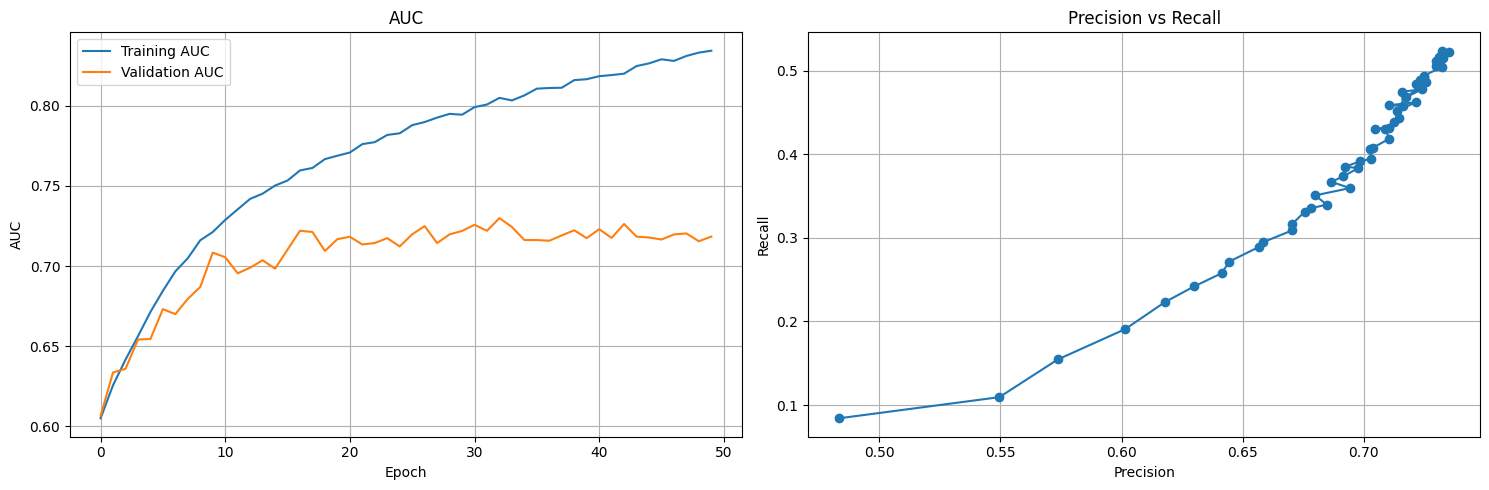

In [5]:
 # Train models
print("Training models...")
model_regr, model_class2, model_class3, *histories = train_models(X_train, y_train, X_test, y_test)

In [13]:
# ===================================================================
# MODEL PREDICTIONS
# ===================================================================
# For regression model
regr_predictions = model_regr.predict(X_test).flatten()
print_metrics('regr', y_test, regr_predictions)

# For binary classification model
class2_predictions_proba = model_class2.predict(X_test)
class2_predictions = (class2_predictions_proba >= 0.5).astype(int)
y_test_binary = (y_test > 0).astype(int)  # Convert returns to binary labels
print_metrics('class2', y_test_binary, class2_predictions, class2_predictions_proba)

# For 3-class classification model
class3_predictions_proba = model_class3.predict(X_test)
class3_predictions = np.argmax(class3_predictions_proba, axis=1)

# Create true labels for 3-class classification
threshold = 0.38
y_test_class3 = np.zeros_like(y_test)
y_test_class3[y_test > threshold] = 2   # Buy class
y_test_class3[(y_test >= -threshold) & (y_test <= threshold)] = 1  # Hold class
y_test_class3[y_test < -threshold] = 0   # Sell class

print_metrics('class3', y_test_class3, class3_predictions, class3_predictions_proba)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

MODEL EVALUATION METRICS: REGR MODEL
MAE: 0.4683
MSE: 0.3404
RMSE: 0.5834
R²: -0.1434

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

MODEL EVALUATION METRICS: CLASS2 MODEL
Accuracy: 0.4875
Precision: 0.4867
Recall: 0.4875
F1 Score: 0.4871

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

MODEL EVALUATION METRICS: CLASS3 MODEL
Accuracy: 0.5294
Precision: 0.5012
Recall: 0.5294
F1 Score: 0.5050



In [14]:
# ===================================================================
# SIGNAL GENERATION
# ===================================================================
# Initialize backtesting parameters
initial_capital = 10000  # $10,000 initial investment
transaction_cost = 5      # $5 per trade

# 1. Regression as 2-class classification
regr_signals_2class = np.zeros_like(regr_predictions)
regr_signals_2class[regr_predictions > 0] = 1   # Buy signal
regr_signals_2class[regr_predictions < 0] = -1   # Sell signal

# 2. Regression as 3-class classification
regr_signals_3class = np.zeros_like(regr_predictions)
regr_signals_3class[regr_predictions > 0.38] = 1   # Buy signal
regr_signals_3class[regr_predictions < -0.38] = -1  # Sell signal

# 3. 2-class classification model signals
class2_signals = np.where(class2_predictions == 1, 1, -1)

# 4. 3-class classification model signals
class3_signals = np.where(class3_predictions == 0, -1, np.where(class3_predictions == 2, 1, 0))


In [15]:
# ===================================================================
# BACKTESTING ALL STRATEGIES
# ===================================================================
# Backtest regression (2-class)
final_capital_regr_2class, regr_trades_2class = backtest_strategy(
    signals=regr_signals_2class, 
    test_prices=test_prices, 
    initial_capital=initial_capital, 
    transaction_cost=transaction_cost
)

# Backtest regression (3-class)
final_capital_regr_3class, regr_trades_3class = backtest_strategy(
    signals=regr_signals_3class, 
    test_prices=test_prices, 
    initial_capital=initial_capital, 
    transaction_cost=transaction_cost
)

# Backtest classification (2-class)
final_capital_class2, class2_trades = backtest_strategy(
    signals=class2_signals, 
    test_prices=test_prices, 
    initial_capital=initial_capital, 
    transaction_cost=transaction_cost
)

# Backtest classification (3-class)
final_capital_class3, class3_trades = backtest_strategy(
    signals=class3_signals, 
    test_prices=test_prices, 
    initial_capital=initial_capital, 
    transaction_cost=transaction_cost
)

# Calculate buy-and-hold benchmark
buy_hold_return = test_prices[-1] / test_prices[0] * initial_capital

In [16]:
# ===================================================================
# CALCULATE ADDITIONAL METRICS FOR REGRESSION AS CLASSIFIER
# ===================================================================
# Regression as 2-class metrics
regr_pred_2class = np.where(regr_predictions > 0, 1, 0)
regr_accuracy_2class = accuracy_score(y_test_binary, regr_pred_2class)
regr_precision_2class = precision_score(y_test_binary, regr_pred_2class)
regr_recall_2class = recall_score(y_test_binary, regr_pred_2class)
regr_f1_2class = f1_score(y_test_binary, regr_pred_2class)
regr_auc_2class = roc_auc_score(y_test_binary, regr_predictions)

# Regression as 3-class metrics
regr_pred_3class = np.zeros_like(regr_predictions)
regr_pred_3class[regr_predictions > threshold] = 2   # Buy class
regr_pred_3class[(regr_predictions >= -threshold) & (regr_predictions <= threshold)] = 1  # Hold
regr_pred_3class[regr_predictions < -threshold] = 0   # Sell class

regr_accuracy_3class = accuracy_score(y_test_class3, regr_pred_3class)
regr_precision_3class = precision_score(y_test_class3, regr_pred_3class, average='weighted')
regr_recall_3class = recall_score(y_test_class3, regr_pred_3class, average='weighted')
regr_f1_3class = f1_score(y_test_class3, regr_pred_3class, average='weighted')

In [17]:
accuracy_class2 = accuracy_score(y_test_binary, class2_predictions)
accuracy_class3 = accuracy_score(y_test_class3, class3_predictions)

In [18]:
# ===================================================================
# PRINT ALL RESULTS
# ===================================================================
print("\n" + "="*50)
print("REGRESSION AS CLASSIFIER METRICS")
print("="*50)
print("2-Class Direction Prediction:")
print(f"Accuracy: {regr_accuracy_2class:.4f}, Precision: {regr_precision_2class:.4f}")
print(f"Recall: {regr_recall_2class:.4f}, F1: {regr_f1_2class:.4f}, AUC: {regr_auc_2class:.4f}")

print("\n3-Class Prediction:")
print(f"Accuracy: {regr_accuracy_3class:.4f}, Precision: {regr_precision_3class:.4f}")
print(f"Recall: {regr_recall_3class:.4f}, F1: {regr_f1_3class:.4f}")

print("\n" + "="*50)
print("BACKTESTING RESULTS")
print("="*50)
print(f"Regression (2-class) final capital: ${final_capital_regr_2class:.2f} (Trades: {regr_trades_2class})")
print(f"Regression (3-class) final capital: ${final_capital_regr_3class:.2f} (Trades: {regr_trades_3class})")
print(f"Classification (2-class) final capital: ${final_capital_class2:.2f} (Trades: {class2_trades})")
print(f"Classification (3-class) final capital: ${final_capital_class3:.2f} (Trades: {class3_trades})")
print(f"Buy-and-hold strategy final capital: ${buy_hold_return:.2f}")

# ===================================================================
# PERFORMANCE COMPARISON
# ===================================================================
print("\n" + "="*50)
print("PERFORMANCE SUMMARY")
print("="*50)
print(f"Best trading strategy: {'Regression (2-class)' if final_capital_regr_2class > final_capital_class2 else 'Classification (2-class)'}")
print(f"Most accurate model: {'3-class Classification' if max(regr_accuracy_2class, regr_accuracy_3class, accuracy_class2, accuracy_class3) == accuracy_class3 else 'Regression (2-class)'}")
print(f"Most profitable vs buy-and-hold: {'Regression (2-class)' if final_capital_regr_2class > buy_hold_return else 'NONE'}")


REGRESSION AS CLASSIFIER METRICS
2-Class Direction Prediction:
Accuracy: 0.4931, Precision: 0.5457
Recall: 0.4994, F1: 0.5215, AUC: 0.4861

3-Class Prediction:
Accuracy: 0.5044, Precision: 0.3812
Recall: 0.5044, F1: 0.3595

BACKTESTING RESULTS
Regression (2-class) final capital: $10400.43 (Trades: 4)
Regression (3-class) final capital: $241.49 (Trades: 30)
Classification (2-class) final capital: $10615.64 (Trades: 4)
Classification (3-class) final capital: $19.61 (Trades: 10)
Buy-and-hold strategy final capital: $10638.26

PERFORMANCE SUMMARY
Best trading strategy: Classification (2-class)
Most accurate model: 3-class Classification
Most profitable vs buy-and-hold: NONE
